In [1]:
# get data
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/airlinepassengers/

Mounted at /content/drive
/content/drive/MyDrive/airlinepassengers


In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from plotnine import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle
%matplotlib inline

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# drop unnecessary columns
train.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

In [5]:
# a function to convert neutral or dissatisfied into 0 and satisfied into 1 else into -1
def satisfaction_Transform(s):
    if s == 'satisfied':
        return 1
    elif s == 'neutral or dissatisfied':
        return 0
    else:
        return -1

# calling function
train['satisfaction'] = train['satisfaction'].apply(satisfaction_Transform)

In [6]:
# find columns with null values
train.isnull().sum().sort_values(ascending=False)

Arrival Delay in Minutes             310
Gender                                 0
Seat comfort                           0
Departure Delay in Minutes             0
Cleanliness                            0
Inflight service                       0
Checkin service                        0
Baggage handling                       0
Leg room service                       0
On-board service                       0
Inflight entertainment                 0
Online boarding                        0
Customer Type                          0
Food and drink                         0
Gate location                          0
Ease of Online booking                 0
Departure/Arrival time convenient      0
Inflight wifi service                  0
Flight Distance                        0
Class                                  0
Type of Travel                         0
Age                                    0
satisfaction                           0
dtype: int64

In [8]:
# filling null values in 'Arrival Delay in Minutes' column with mean value
train['Arrival Delay in Minutes'] = train['Arrival Delay in Minutes'].fillna(train['Arrival Delay in Minutes'].mean())

In [10]:
# replace categorical data with numbers usin pandas library 'get_dummies'
categorical_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
new_train = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
train_df = new_train.copy()

In [16]:
train_df.columns

Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction', 'Gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus'],
      dtype='object')

In [15]:
tab = train_df[["Gender_Male", "Customer Type_disloyal Customer","Type of Travel_Personal Travel","Class_Eco","Class_Eco Plus"]]
tab.head()

,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,1,0,1,0,1
1,1,1,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,1,0,0,0,0


In [19]:
# scaling columns with 'StandardScaler()' to give all features same importance
train_cols = train_df[['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']]
scaler = StandardScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(train_cols), columns = train_cols.columns)

x_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
train_df[x_cols] = scaled_train

In [17]:
tab = train_df[['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']]
tab.head()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
0,13,460,25,18.0
1,25,235,1,6.0
2,26,1142,0,0.0
3,25,562,11,9.0
4,61,214,0,0.0


In [20]:
tab = train_df[['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']]
tab.head()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
0,-1.745279,-0.731539,0.266393,0.073014
1,-0.951360,-0.957184,-0.361375,-0.237539
2,-0.885200,-0.047584,-0.387532,-0.392816
3,-0.951360,-0.629246,-0.099805,-0.159901
4,1.430397,-0.978244,-0.387532,-0.392816


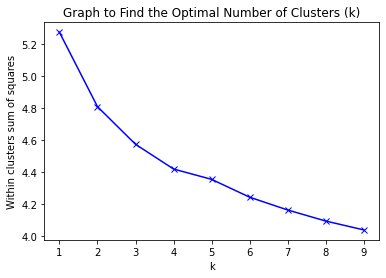

In [23]:
# elbow function to find the optimal number of clusters
RSEED = 42
def elbow_function(df):
    sse = []
    K = range(1,10)
    for k in K:
        # in each iteration create a model with clusters=k
        kModel = KMeans(n_clusters=k, init = 'k-means++', random_state=RSEED).fit(df)
        kModel.fit(df)
        sse.append(sum(np.min(cdist(df, kModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

    # plot the graph
    plt.plot(K, sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Within clusters sum of squares')
    plt.title(f'Graph to Find the Optimal Number of Clusters (k)')
    plt.show()

elbow_function(train_df)

In [24]:
# kmeans = KMeans(n_clusters=4, random_state=RSEED)
kmeans = KMeans(n_clusters=4, init = 'k-means++', random_state=RSEED)
y = kmeans.fit_predict(train_df)

In [25]:
# function to assign the observations to the clusters created by K-Means
def get_divided_clusters(labels):
    outcome_df = dm.copy()
    
    outcome_df["cluster"] = labels
    divided_cluster = outcome_df.groupby("cluster").mean().reset_index().melt(id_vars="cluster")
    divided_cluster = divided_cluster["variable"].str.split("_" , expand=True).join(divided_cluster)
    divided_cluster = divided_cluster.rename({0 : "baseVar" , 1:"outcome"} , axis=1)
    divided_cluster["cluster"] = divided_cluster["cluster"].astype("category") 
    return divided_cluster

In [26]:
# function to return ggplots
def get_ggplots():
  
  plot = (
    ggplot(cluster_distribution[~cluster_distribution["outcome"].isna()], aes(x="outcome", y="value", fill="cluster"))
    + geom_col(position="fill")
    + labs(x='Column Value', y='Observations as a Percentage')
    + coord_flip()
    + facet_wrap("~ baseVar")
    + theme(figure_size=(4, 3))
    + scale_fill_manual(values=('lightcoral', 'indianred', 'brown', 'maroon'))
  )

  return plot

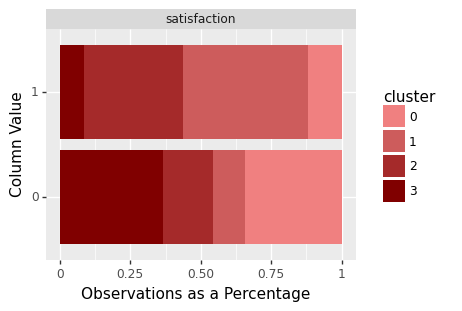

<ggplot: (88871346261)>

In [29]:
# satisfaction plot
dm = pd.get_dummies(train, columns=['satisfaction'])
cluster_distribution = get_divided_clusters(kmeans.labels_)
get_ggplots()

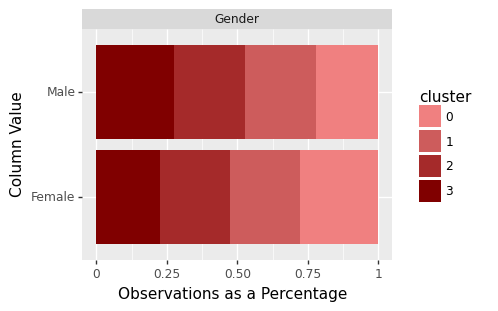

<ggplot: (88871461166)>

In [30]:
# gender plot
dm = pd.get_dummies(train, columns=['Gender'])
cluster_distribution = get_divided_clusters(kmeans.labels_)
get_ggplots()

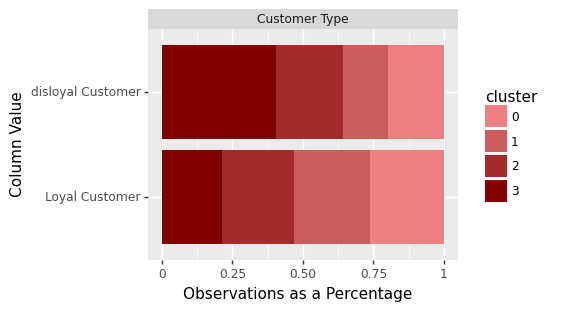

<ggplot: (88879325510)>

In [31]:
# customer type plot
dm = pd.get_dummies(train, columns=['Customer Type'])
cluster_distribution = get_divided_clusters(kmeans.labels_)
get_ggplots()

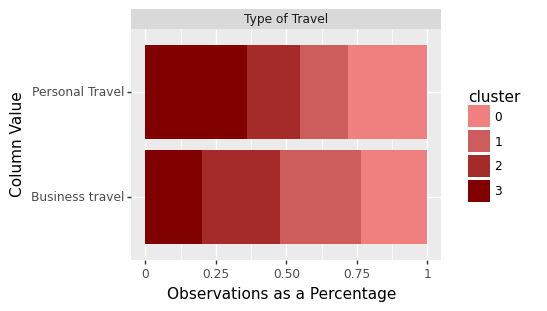

<ggplot: (88879331316)>

In [27]:
# travel type plot
dm = pd.get_dummies(train, columns=['Type of Travel'])
cluster_distribution = get_divided_clusters(kmeans.labels_)
get_ggplots()

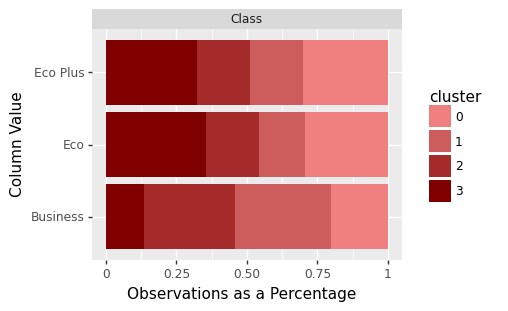

<ggplot: (88869258710)>

In [32]:
# class plot
dm = pd.get_dummies(train, columns=['Class'])
cluster_distribution = get_divided_clusters(kmeans.labels_)
get_ggplots()

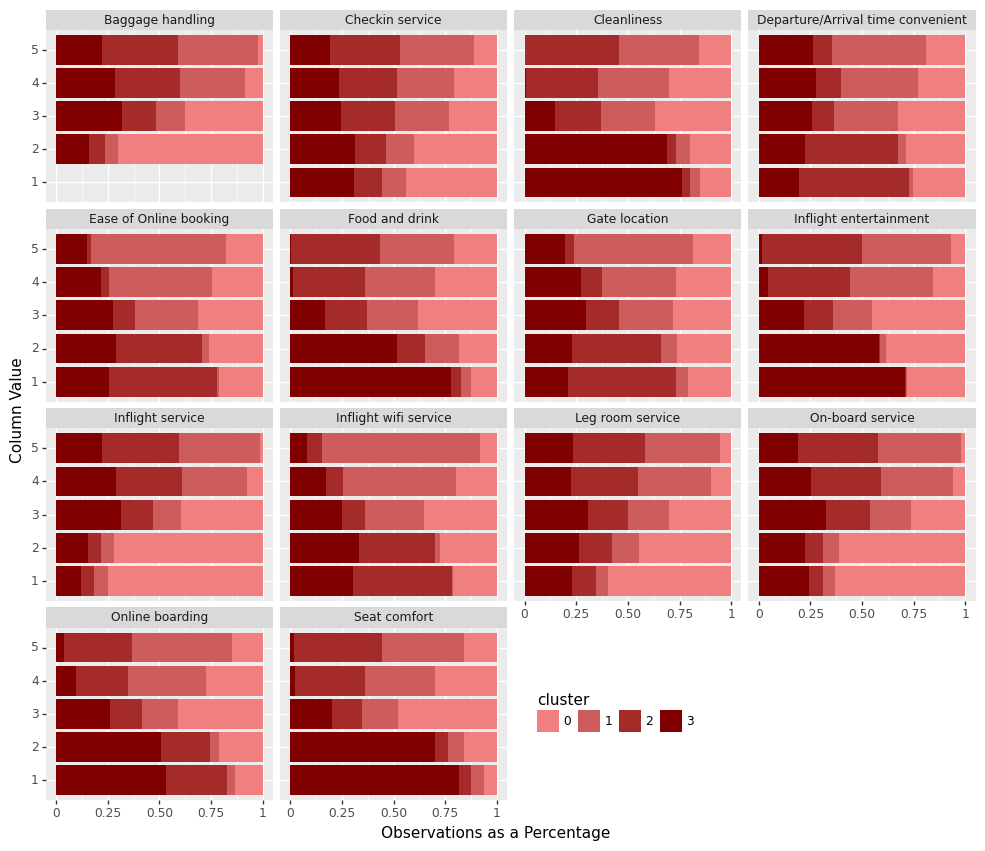

<ggplot: (88879973642)>

In [34]:
# cluster distribution for passenger rating columns
cols = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service',
       'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']

dm = pd.get_dummies(train, columns=cols, drop_first=True)
cluster_distribution = get_divided_clusters(kmeans.labels_)

(
    ggplot(cluster_distribution[~cluster_distribution["outcome"].isna()], aes(x="outcome", y="value", fill="cluster"))
    + geom_col(position="fill")
    + labs(x='Column Value', y='Observations as a Percentage')
    + coord_flip()
    + facet_wrap("~ baseVar")
    + theme(figure_size=(12, 10), legend_position = (0.6, 0.2)) 
    + scale_fill_manual(values=('lightcoral', 'indianred', 'brown', 'maroon'))
)